# Temporal Trends




In [9]:
# -------------------------------------------------------------------
# Setup cell — place this at the top of every analysis notebook
# -------------------------------------------------------------------
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
import statsmodels.formula.api as smf


df = pd.read_csv("../datasets/customer_shopping_data_v10.csv")
sns.set_theme(style="whitegrid")

color1 = '#FF9E9D'  # Coral Pink
color2 = '#FFC785'  # Peach
color3 = '#FFF59D'  # Light Lemon
color4 = '#A0E6A6'  # Mint Green
color5 = '#87C8FF'  # Sky Blue
color6 = '#C4A2FF'  # Lavender

1. invoice_date ↔ daily_total_spend <br>
What are the trends and fluctuations in daily revenue?

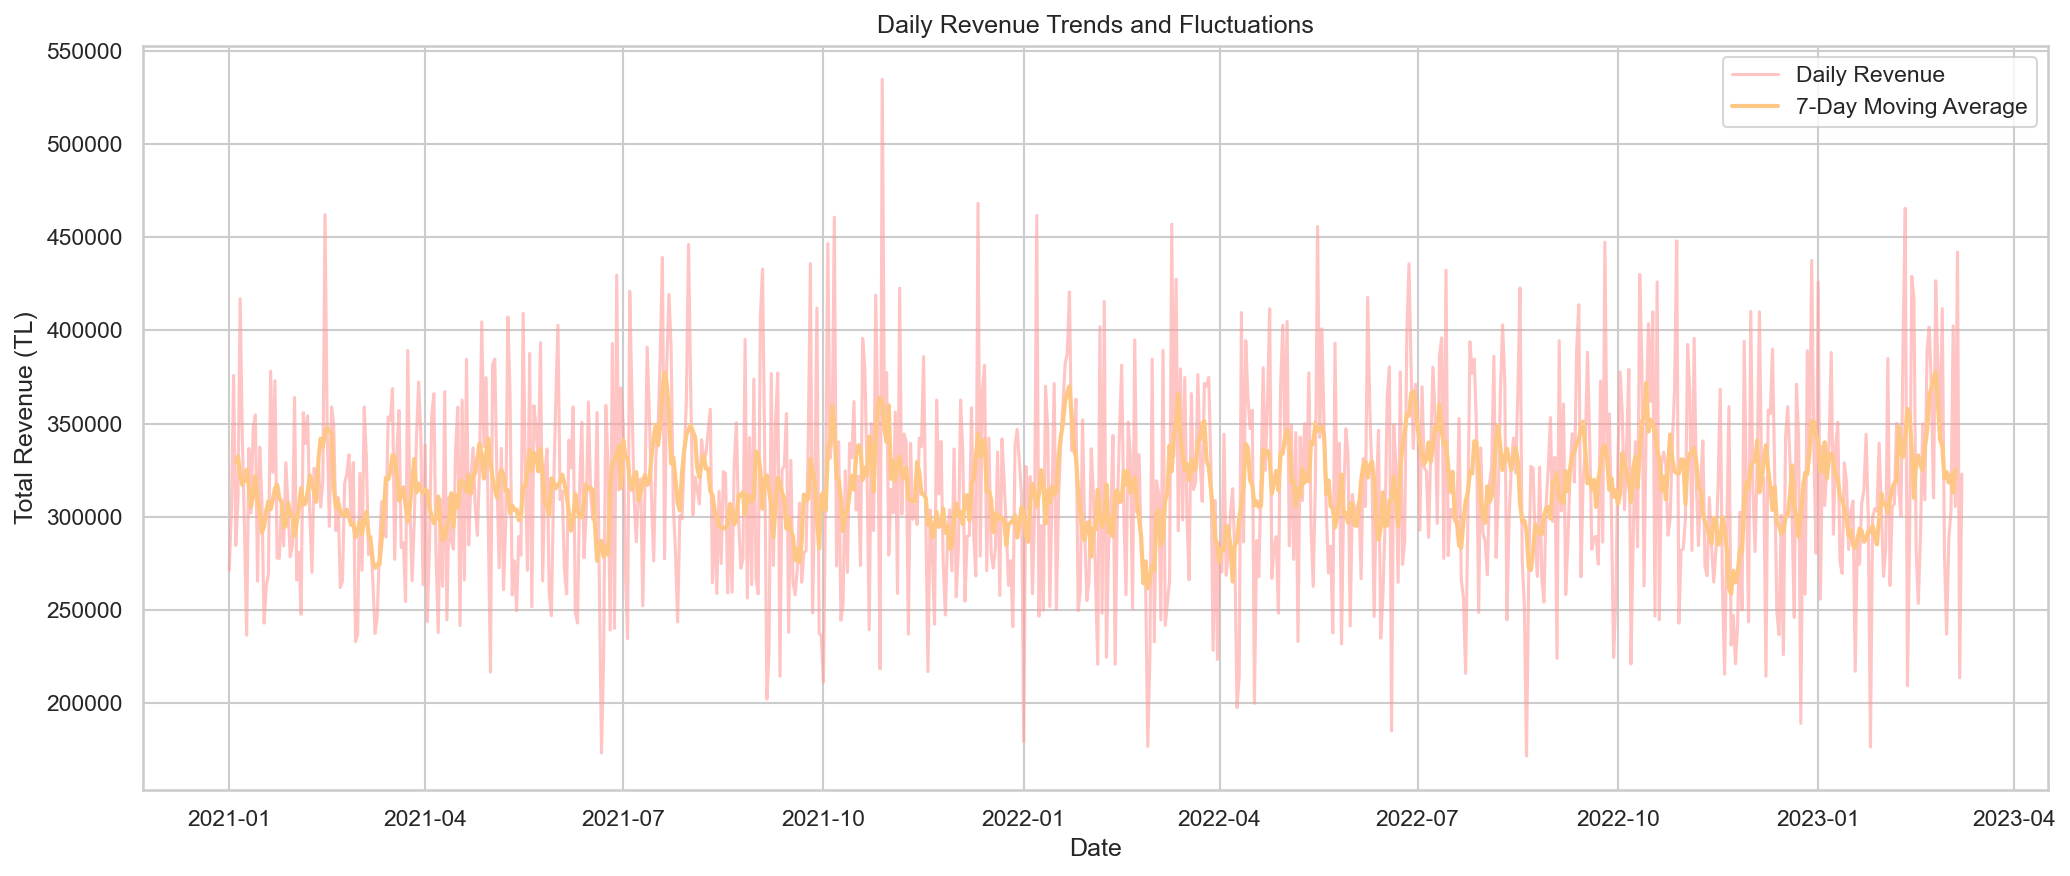


Summary Statistics:
count       797.000000
mean     315565.613864
std       54995.142183
min      171339.480000
25%      276255.240000
50%      312005.520000
75%      350833.120000
max      534906.860000
Name: daily_total, dtype: float64
                            OLS Regression Results                            
Dep. Variable:            daily_total   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.335
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.248
Time:                        14:42:28   Log-Likelihood:                -9829.0
No. Observations:                 797   AIC:                         1.966e+04
Df Residuals:                     795   BIC:                         1.967e+04
Df Model:                           1                                         
Covariance Type:            nonrobust             

In [10]:
# 1. Ensure invoice_date is datetime
df["invoice_date"] = pd.to_datetime(df["invoice_date"])

# 2. Group by date and sum total_price
daily_revenue = (
    df.groupby(df["invoice_date"].dt.date)["total_price"]
    .sum()
    .reset_index(name="daily_total")
)

# 3. Sort by date
daily_revenue = daily_revenue.sort_values("invoice_date")

# 4. Compute 7-day moving average for smoothing
daily_revenue["moving_avg"] = daily_revenue["daily_total"].rolling(window=7, center=True).mean()

# 5. Plot daily revenue with moving average
plt.figure(figsize=(14,6), dpi=150)
plt.plot(daily_revenue["invoice_date"], daily_revenue["daily_total"], label="Daily Revenue", alpha=0.6, color=color1)
plt.plot(daily_revenue["invoice_date"], daily_revenue["moving_avg"], label="7-Day Moving Average", linewidth=2, color=color2)
plt.xlabel("Date")
plt.ylabel("Total Revenue (TL)")
plt.title("Daily Revenue Trends and Fluctuations")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Summary statistics
print("\nSummary Statistics:")
print(daily_revenue["daily_total"].describe())

# Create time index
daily_revenue["time_index"] = range(1, len(daily_revenue)+1)

# Define X and y
X = sm.add_constant(daily_revenue["time_index"])
y = daily_revenue["daily_total"]

# Fit OLS regression
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

# Interpret p-value
p_value = model.pvalues["time_index"]
coef = model.params["time_index"]

if p_value < 0.05:
    trend = "increasing" if coef > 0 else "decreasing"
    print(f"\n✅ Significant {trend} trend over time. (p={p_value:.4f})")
else:
    print(f"\n❌ No significant trend over time. (p={p_value:.4f})")



2. invoice_date ↔ daily_transaction_count <br>
How does daily transaction volume vary seasonally and periodically?

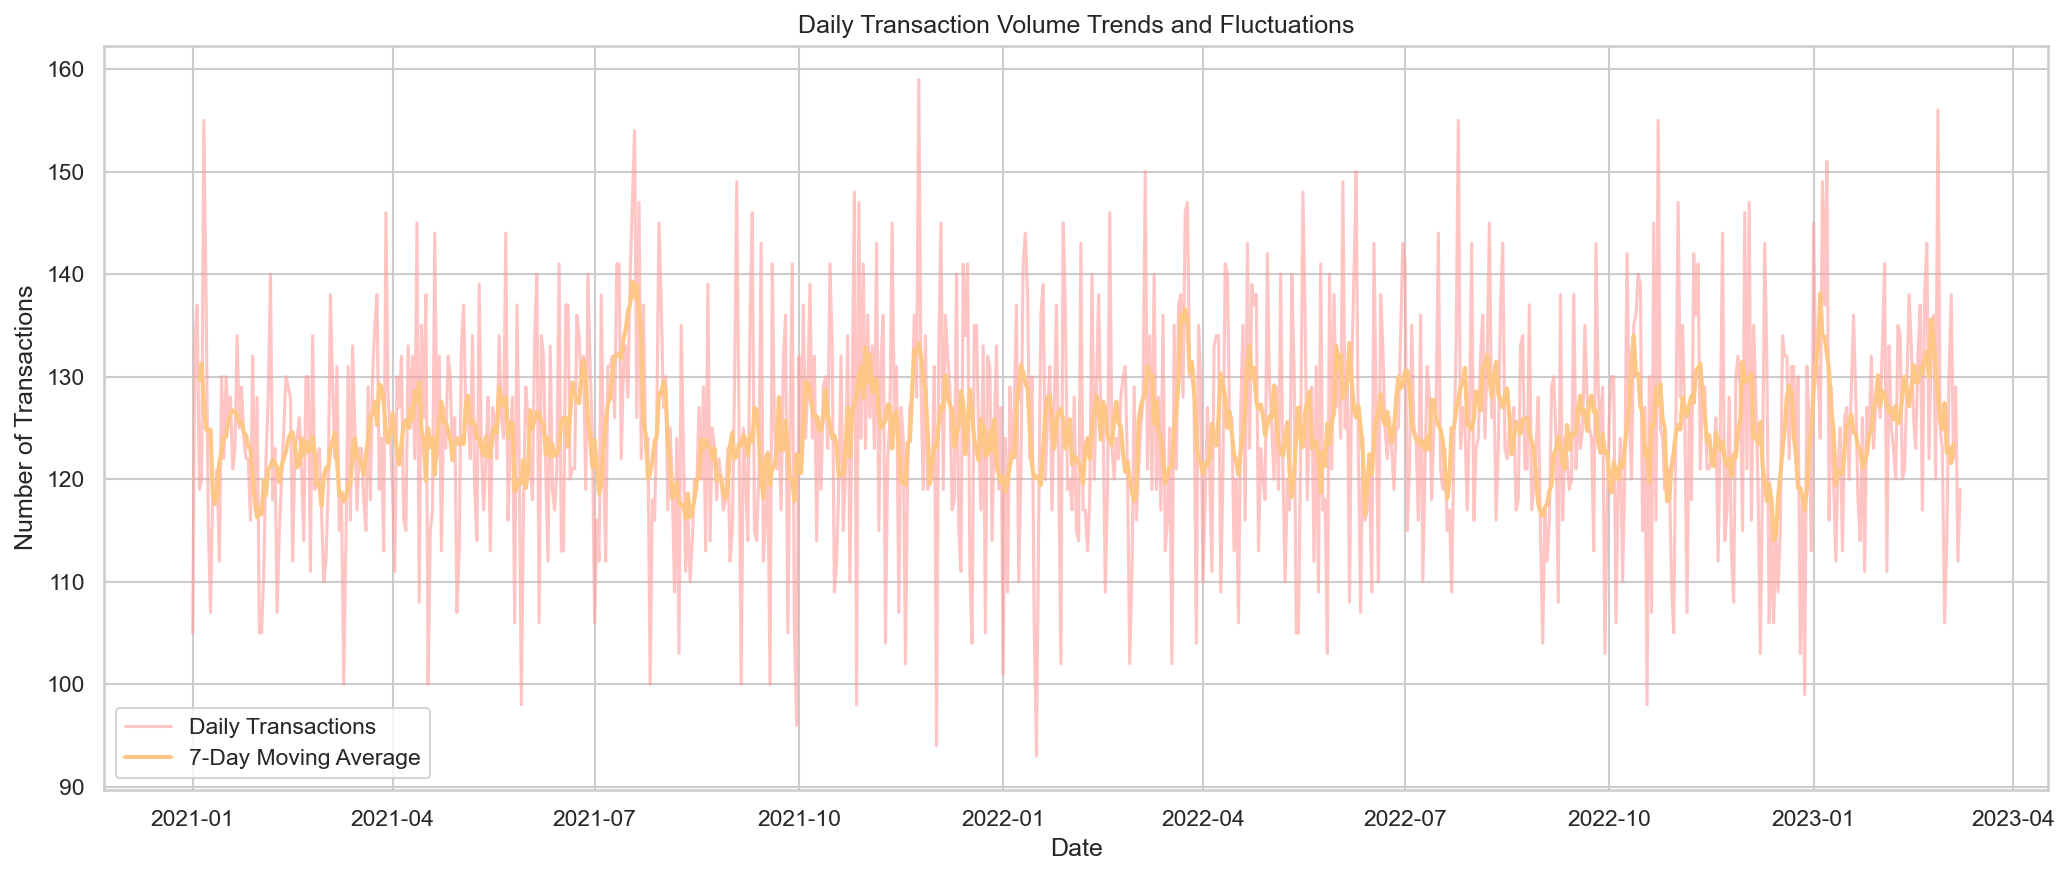

                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.452
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.118
Time:                        14:42:28   Log-Likelihood:                -3034.6
No. Observations:                 797   AIC:                             6073.
Df Residuals:                     795   BIC:                             6083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.7395      0.774    159.923      0.0

In [11]:
# 1. Group by date and count transactions
daily_transactions = (
    df.groupby(df["invoice_date"].dt.date)
    .size()
    .reset_index(name="transaction_count")
)

# 2. Sort by date
daily_transactions = daily_transactions.sort_values("invoice_date")

# 3. Create time index
daily_transactions["time_index"] = range(1, len(daily_transactions)+1)

# 4. Compute 7-day moving average
daily_transactions["moving_avg"] = (
    daily_transactions["transaction_count"].rolling(window=7, center=True).mean()
)

# 5. Plot daily transaction volume with moving average
plt.figure(figsize=(14,6), dpi=150)
plt.plot(
    daily_transactions["invoice_date"],
    daily_transactions["transaction_count"],
    label="Daily Transactions",
    alpha=0.6,
    color=color1
)
plt.plot(
    daily_transactions["invoice_date"],
    daily_transactions["moving_avg"],
    label="7-Day Moving Average",
    linewidth=2,
    color=color2
)
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.title("Daily Transaction Volume Trends and Fluctuations")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Prepare regression data
X = sm.add_constant(daily_transactions["time_index"])
y = daily_transactions["transaction_count"]

# 7. Fit OLS regression
model = sm.OLS(y, X).fit()

# 8. Print regression summary
print(model.summary())

# 9. Interpret p-value
p_value = model.pvalues["time_index"]
coef = model.params["time_index"]

if p_value < 0.05:
    trend = "increasing" if coef > 0 else "decreasing"
    print(f"\n✅ Significant {trend} trend in transaction volume over time. (p={p_value:.4f})")
else:
    print(f"\n❌ No significant trend in transaction volume over time. (p={p_value:.4f})")


4. season ↔ total_spend <br>
Are seasonal differences in revenue significant?


Summary Statistics by Season:


,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
Fall,22680.0,2537.39,4258.55,5.23,136.35,600.17,2700.72,26250.0
Spring,23914.0,2525.35,4162.79,5.23,130.75,600.17,2700.72,26250.0
Summer,23093.0,2537.34,4237.62,5.23,136.35,600.17,2700.72,26250.0
Winter,29770.0,2518.36,4230.89,5.23,136.35,600.17,2700.72,26250.0


/var/folders/tw/ngdtxtj50klg2qdy83nmydxh0000gn/T/ipykernel_1678/3111958420.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


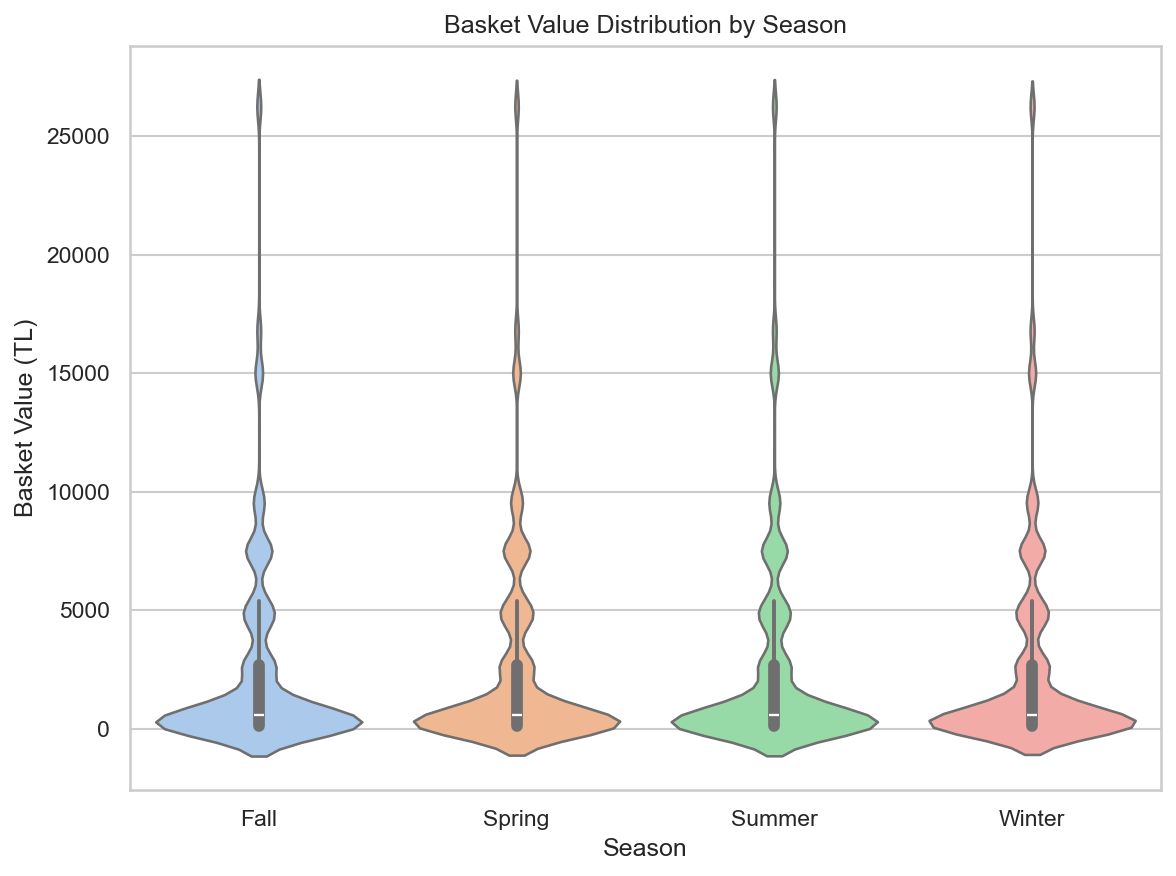


Regression Summary (ANOVA):
                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1287
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.943
Time:                        15:08:20   Log-Likelihood:            -9.7141e+05
No. Observations:               99457   AIC:                         1.943e+06
Df Residuals:                   99453   BIC:                         1.943e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inter

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 1. Season kategorik olsun
df["season"] = df["season"].astype("category")

# 2. Descriptive statistics: count, mean, std, min, percentiles, max
desc = df.groupby("season", observed=False)["total_price"].describe().round(2)

print("\nSummary Statistics by Season:")
display(desc)

# 3. Violin plot
plt.figure(figsize=(8,6), dpi=150)
sns.violinplot(
    x="season",
    y="total_price",
    data=df,
    palette="pastel",
    inner="box"
)
plt.xlabel("Season")
plt.ylabel("Basket Value (TL)")
plt.title("Basket Value Distribution by Season")
plt.tight_layout()
plt.show()

# 4. OLS regression (ANOVA)
model = smf.ols(
    formula="total_price ~ C(season)",
    data=df
).fit()

# 5. Regression summary
print("\nRegression Summary (ANOVA):")
print(model.summary())

# 6. Interpret global F-test
p_value = model.f_pvalue

if p_value < 0.05:
    print(f"\n✅ Significant differences: Seasonal variations in revenue are statistically significant. (p={p_value:.4f})")
else:
    print(f"\n❌ No significant differences in revenue across seasons. (p={p_value:.4f})")


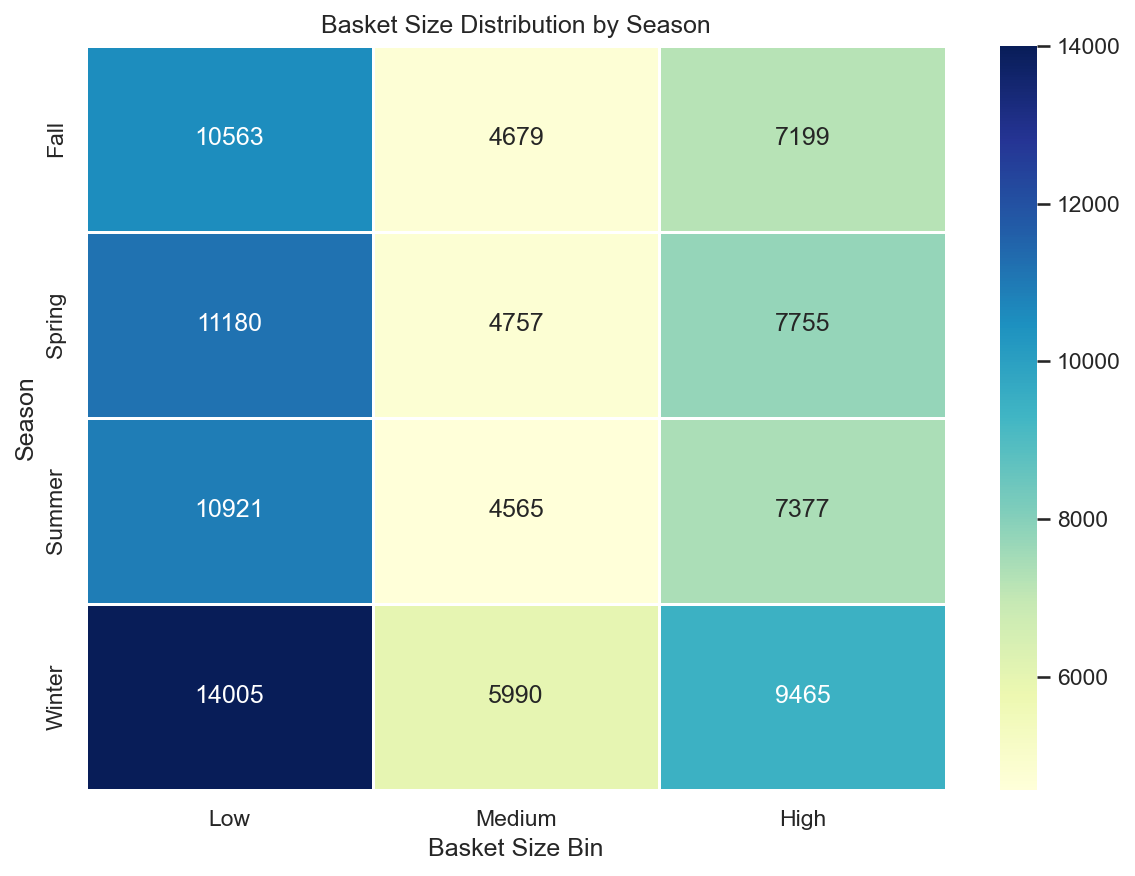


Observed counts:
basket_bin    Low  Medium  High
season                         
Fall        10563    4679  7199
Spring      11180    4757  7755
Summer      10921    4565  7377
Winter      14005    5990  9465

Expected counts under H0:
basket_bin       Low   Medium     High
season                                
Fall        10637.23  4556.53  7247.24
Spring      11230.21  4810.54  7651.24
Summer      10837.26  4642.22  7383.52
Winter      13964.30  5981.71  9514.00

Chi² = 8.6778 (df = 6)  p = 0.1925
❌ No significant association between season and basket size. (p=0.1925)


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Basket bins
bins = [0, 500, 2000, df["total_price"].max()]
labels = ["Low", "Medium", "High"]

# Bin kategorisini ekle
df["basket_bin"] = pd.cut(df["total_price"], bins=bins, labels=labels, right=False)

# Kontenjans tablosu
heatmap_data = pd.crosstab(df["season"], df["basket_bin"])

# Heatmap çizimi
plt.figure(figsize=(8,6), dpi=150)
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5
)

plt.title("Basket Size Distribution by Season")
plt.xlabel("Basket Size Bin")
plt.ylabel("Season")
plt.tight_layout()
plt.show()

# Chi-square testi
chi2, p, dof, expected = chi2_contingency(heatmap_data)

print("\nObserved counts:")
print(heatmap_data)

print("\nExpected counts under H0:")
print(pd.DataFrame(expected, index=heatmap_data.index, columns=heatmap_data.columns).round(2))

print(f"\nChi² = {chi2:.4f} (df = {dof})  p = {p:.4f}")

if p < 0.05:
    print(f"✅ Significant association between season and basket size. (p={p:.4f})")
else:
    print(f"❌ No significant association between season and basket size. (p={p:.4f})")


5. season ↔ transaction_count <br>
Do seasons influence the number of transactions?


Average daily transaction count per season:
   season  avg_transaction_count
3  Winter              37.352572
1  Spring              30.005019
2  Summer              28.974906
0    Fall              28.456713

Descriptive statistics per season:


,season,count,mean,std,min,25%,50%,75%,max
0,Fall,797.0,28.456713,52.637470,0.0,0.0,0.0,0.0,159.0
1,Spring,797.0,30.005019,53.552069,0.0,0.0,0.0,0.0,150.0
2,Summer,797.0,28.974906,53.148525,0.0,0.0,0.0,0.0,155.0
3,Winter,797.0,37.352572,57.429047,0.0,0.0,0.0,115.0,156.0


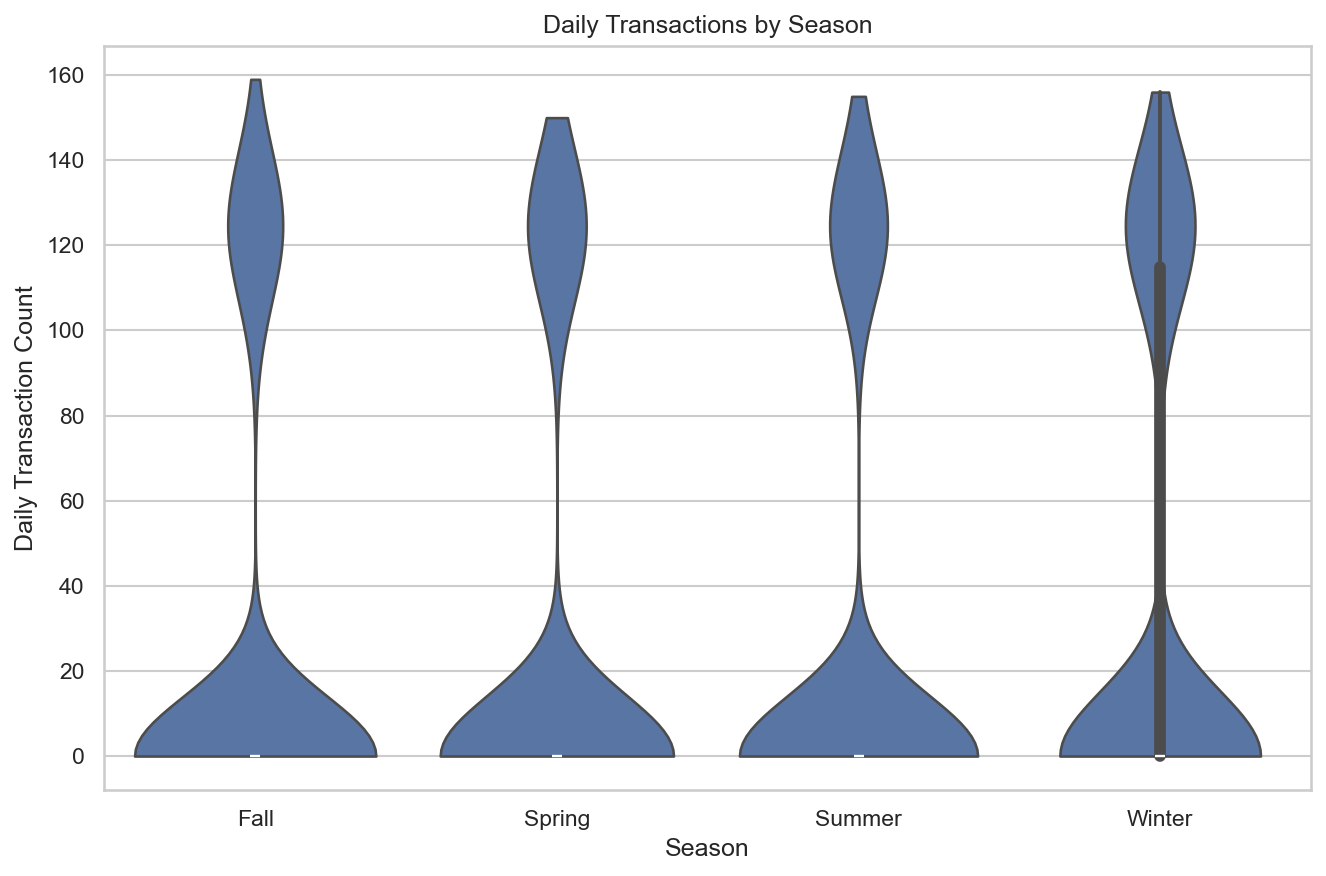


OLS Regression (ANOVA) Results:
                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.677
Date:                Sat, 28 Jun 2025   Prob (F-statistic):            0.00290
Time:                        14:48:38   Log-Likelihood:                -17252.
No. Observations:                3188   AIC:                         3.451e+04
Df Residuals:                    3184   BIC:                         3.454e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
I

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 1. Ensure season is categorical
df["season"] = df["season"].astype("category")

# 2. Daily transaction count with season
daily_counts = (
    df.groupby([df["invoice_date"].dt.date, "season"], observed=False)
      .size()
      .reset_index(name="transaction_count")
)

# 3. Average transaction count per season
season_avg = (
    daily_counts.groupby("season", observed=False)["transaction_count"]
    .mean()
    .reset_index(name="avg_transaction_count")
    .sort_values("avg_transaction_count", ascending=False)
)

# 4. Descriptive statistics table per season
description_table = (
    daily_counts.groupby("season", observed=False)["transaction_count"]
    .describe()
    .reset_index()
)
print("\nDescriptive statistics per season:")
display(description_table)

# 5. Violin plot
plt.figure(figsize=(9,6), dpi=150)
sns.violinplot(
    data=daily_counts,
    x="season",
    y="transaction_count",
    inner="box",
    cut=0
)
plt.xlabel("Season")
plt.ylabel("Daily Transaction Count")
plt.title("Daily Transactions by Season")
plt.tight_layout()
plt.show()

# 6. OLS Regression (ANOVA)
model = smf.ols(
    formula="transaction_count ~ C(season)",
    data=daily_counts
).fit()

print("\nOLS Regression (ANOVA) Results:")
print(model.summary())

# 7. Interpret p-value
p_value = model.f_pvalue
if p_value < 0.05:
    print(f"\n✅ Significant differences: Seasons affect transaction volume. (p={p_value:.4f})")
else:
    print(f"\n❌ No significant differences: Seasons do not significantly affect transaction volume. (p={p_value:.4f})")


6. is_weekday ↔ transaction_count <br>
What is the weekday vs. weekend difference in revenue and transaction volume?


Average daily transaction count per weekday/weekend:
  is_weekday  avg_transaction_count
0          0              35.459222
1          1              89.329987

Descriptive statistics of daily transaction count per weekday/weekend:


,is_weekday,count,mean,std,min,25%,50%,75%,max
0,0,797.0,35.459222,56.389349,0.0,0.0,0.0,112.0,156.0
1,1,797.0,89.329987,57.294183,0.0,0.0,120.0,129.0,159.0



Daily Transaction Count Regression Results:
                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     357.9
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           3.66e-72
Time:                        14:52:23   Log-Likelihood:                -8701.0
No. Observations:                1594   AIC:                         1.741e+04
Df Residuals:                    1592   BIC:                         1.742e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

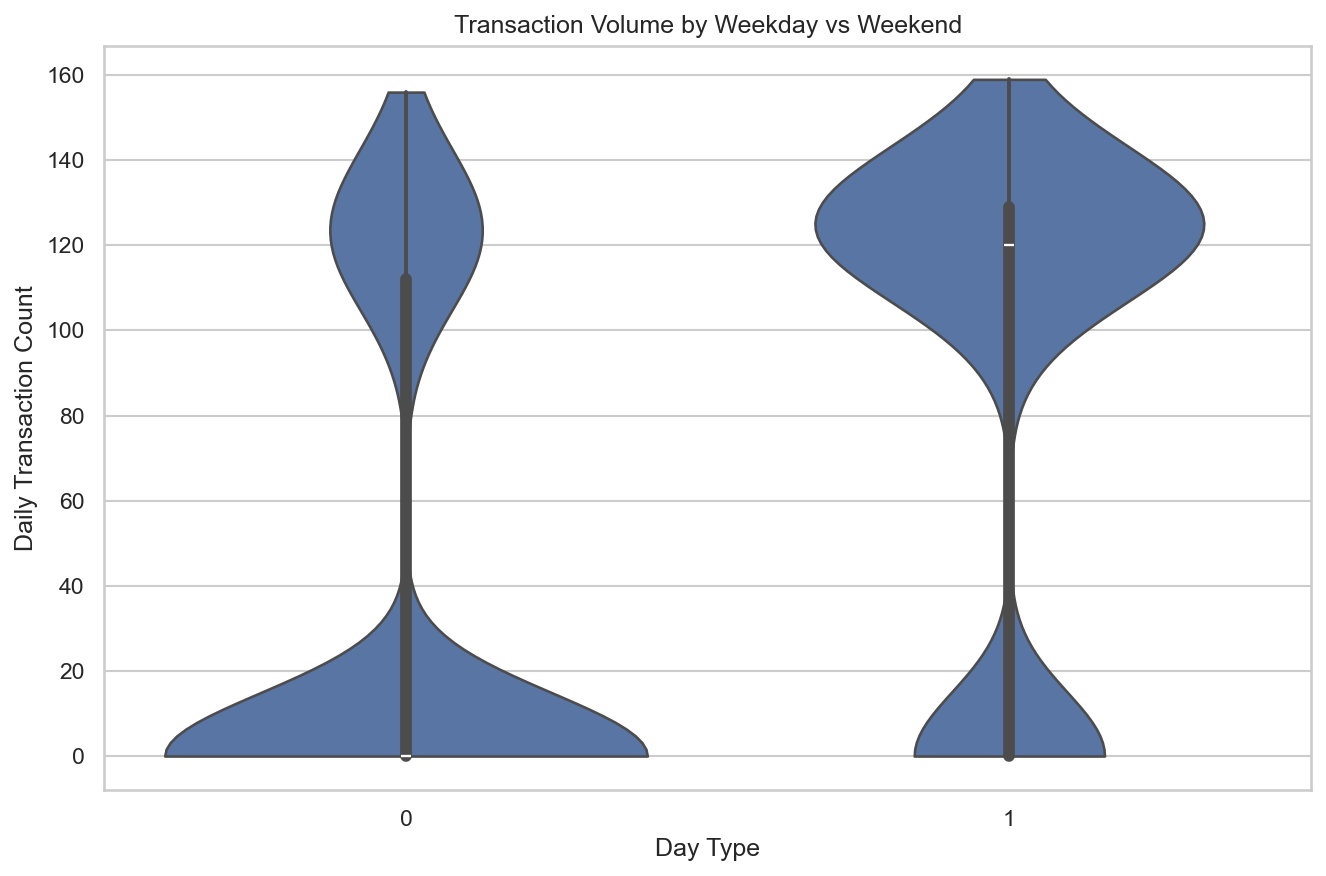

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Ensure is_weekday is categorical (in case it's a fresh cell)
df["is_weekday"] = df["is_weekday"].astype("category")

# Daily transaction counts
daily_counts = (
    df.groupby([df["invoice_date"].dt.date, "is_weekday"], observed=False)
      .size()
      .reset_index(name="transaction_count")
)

# Average daily transaction count
count_avg = (
    daily_counts.groupby("is_weekday", observed=False)["transaction_count"]
      .mean()
      .reset_index(name="avg_transaction_count")
)

# Descriptive statistics
count_desc = (
    daily_counts.groupby("is_weekday", observed=False)["transaction_count"]
      .describe()
      .reset_index()
)

print("\nDescriptive statistics of daily transaction count per weekday/weekend:")
display(count_desc)

# OLS regression on transaction count
model_count = smf.ols(
    formula="transaction_count ~ C(is_weekday)",
    data=daily_counts
).fit()

print("\nDaily Transaction Count Regression Results:")
print(model_count.summary())

p_count = model_count.f_pvalue
if p_count < 0.05:
    print(f"✅ Significant difference in transaction volume between weekday and weekend. (p={p_count:.4f})")
else:
    print(f"❌ No significant difference in transaction volume. (p={p_count:.4f})")

# Violin plot of transaction count
plt.figure(figsize=(9,6), dpi=150)
sns.violinplot(
    data=daily_counts,
    x="is_weekday",
    y="transaction_count",
    inner="box",
    cut=0
)
plt.xlabel("Day Type")
plt.ylabel("Daily Transaction Count")
plt.title("Transaction Volume by Weekday vs Weekend")
plt.tight_layout()
plt.show()


is weekday basket value


Average basket value per weekday/weekend:
  is_weekday  avg_total_spend
0          0      2507.657879
1          1      2537.177298

Descriptive statistics of basket value per weekday/weekend:


,is_weekday,count,mean,std,min,25%,50%,75%,max
0,0,28261.0,2507.657879,4229.934433,5.23,130.75,600.17,2700.72,26250.0
1,1,71196.0,2537.177298,4219.511837,5.23,136.35,600.17,2700.72,26250.0



Basket Value Regression Results:
                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9888
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.320
Time:                        14:52:38   Log-Likelihood:            -9.7141e+05
No. Observations:               99457   AIC:                         1.943e+06
Df Residuals:                   99455   BIC:                         1.943e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
In

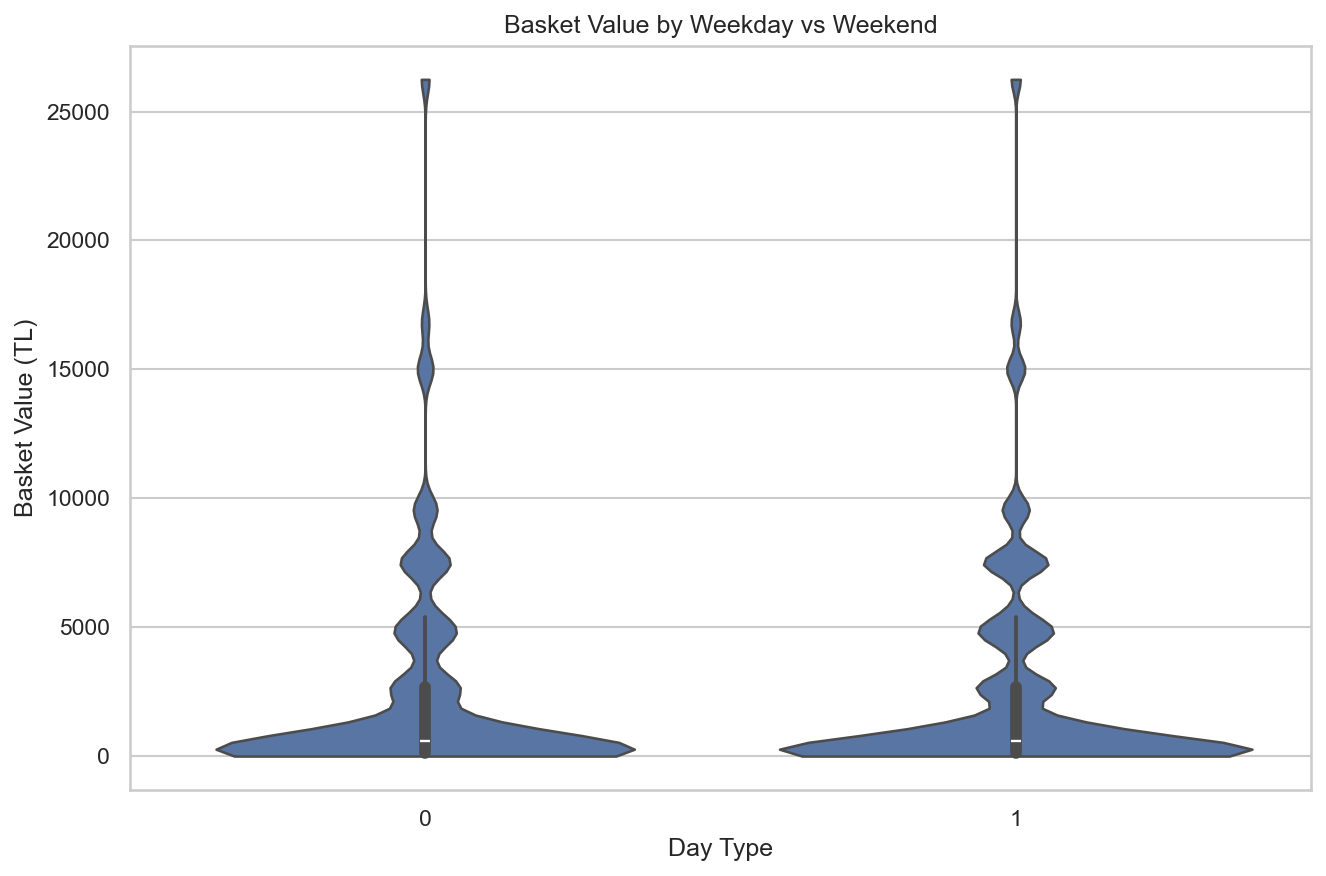

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Ensure is_weekday is categorical
df["is_weekday"] = df["is_weekday"].astype("category")

# Average basket value
revenue_avg = (
    df.groupby("is_weekday", observed=False)["total_price"]
      .mean()
      .reset_index(name="avg_total_spend")
)

# Descriptive statistics
revenue_desc = (
    df.groupby("is_weekday", observed=False)["total_price"]
      .describe()
      .reset_index()
)

print("\nDescriptive statistics of basket value per weekday/weekend:")
display(revenue_desc)

# OLS regression on basket value
model_revenue = smf.ols(
    formula="total_price ~ C(is_weekday)",
    data=df
).fit()

print("\nBasket Value Regression Results:")
print(model_revenue.summary())

p_revenue = model_revenue.f_pvalue
if p_revenue < 0.05:
    print(f"✅ Significant difference in basket value between weekday and weekend. (p={p_revenue:.4f})")
else:
    print(f"❌ No significant difference in basket value. (p={p_revenue:.4f})")

# Violin plot of basket value
plt.figure(figsize=(9,6), dpi=150)
sns.violinplot(
    data=df,
    x="is_weekday",
    y="total_price",
    inner="box",
    cut=0
)
plt.xlabel("Day Type")
plt.ylabel("Basket Value (TL)")
plt.title("Basket Value by Weekday vs Weekend")
plt.tight_layout()
plt.show()


7. is_holiday ↔ total_spend <br>
How do official holidays impact sales?


Average basket value per holiday/non-holiday:
  is_holiday  avg_basket_value
0          0       2531.859694
1          1       2521.941367

Descriptive statistics of basket value per holiday/non-holiday:
  is_holiday    count         mean          std   min     25%     50%  \
0          0  68668.0  2531.859694  4212.010558  5.23  136.35  600.17   
1          1  30789.0  2521.941367  4245.783822  5.23  130.75  600.17   

       75%      max  
0  2700.72  26250.0  
1  2700.72  26250.0  


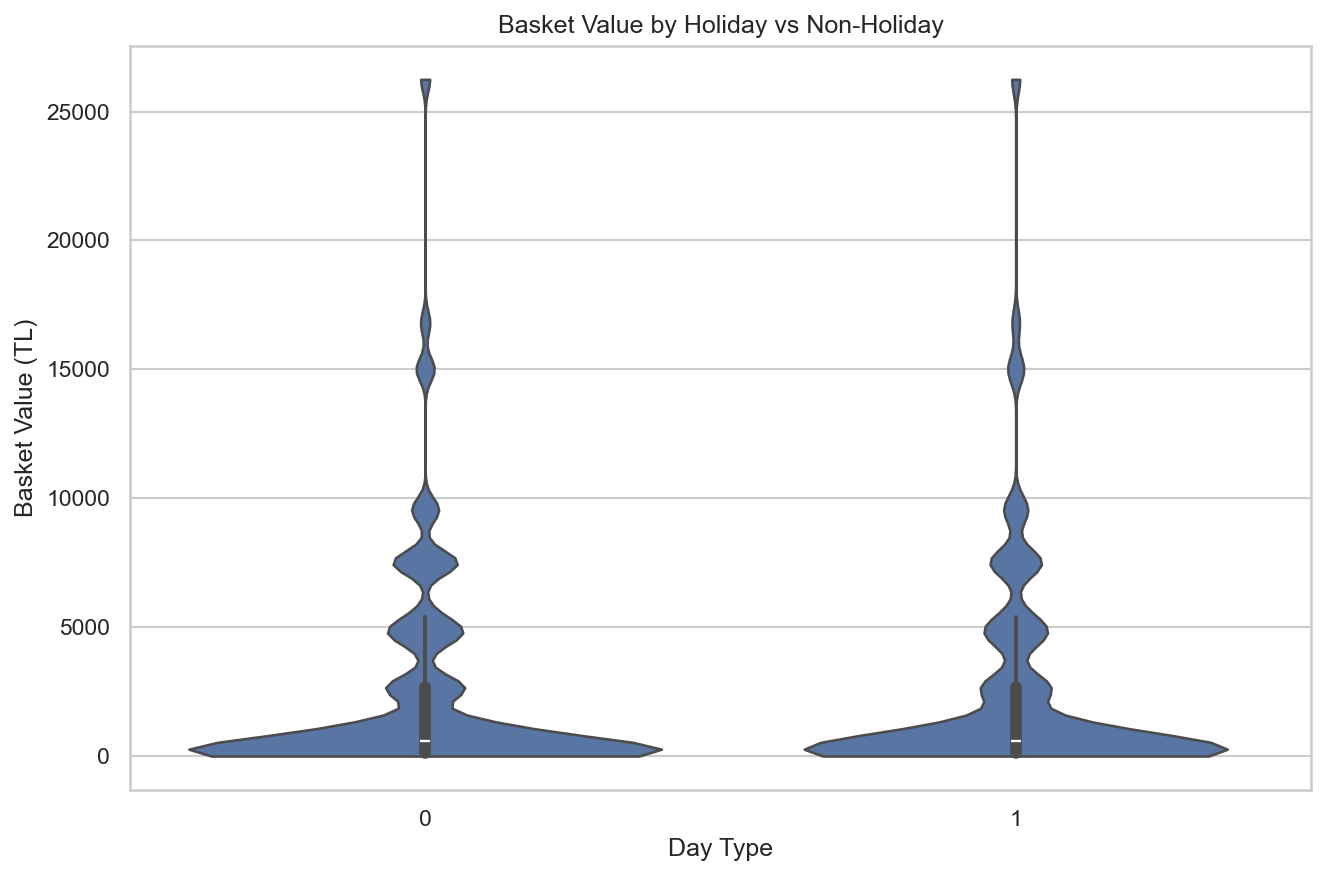


OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1173
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.732
Time:                        14:56:56   Log-Likelihood:            -9.7141e+05
No. Observations:               99457   AIC:                         1.943e+06
Df Residuals:                   99455   BIC:                         1.943e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept  

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 1. Ensure is_holiday is categorical
df["is_holiday"] = df["is_holiday"].astype("category")

# 2. Average basket value per holiday/non-holiday
holiday_avg = (
    df.groupby("is_holiday", observed=False)["total_price"]
      .mean()
      .reset_index(name="avg_basket_value")
)


# 3. Descriptive statistics
desc_table = (
    df.groupby("is_holiday", observed=False)["total_price"]
      .describe()
      .reset_index()
)
print("\nDescriptive statistics of basket value per holiday/non-holiday:")
display(desc_table)

# 4. Violin plot visualization
plt.figure(figsize=(9,6), dpi=150)
sns.violinplot(
    data=df,
    x="is_holiday",
    y="total_price",
    inner="box",
    cut=0
)
plt.xlabel("Day Type")
plt.ylabel("Basket Value (TL)")
plt.title("Basket Value by Holiday vs Non-Holiday")
plt.tight_layout()
plt.show()

# 5. OLS regression
model = smf.ols(
    formula="total_price ~ C(is_holiday)",
    data=df
).fit()

print("\nOLS Regression Results:")
print(model.summary())

# 6. Interpret p-value
p_value = model.f_pvalue
if p_value < 0.05:
    print(f"\n✅ Significant difference in basket value between holidays and non-holidays. (p={p_value:.4f})")
else:
    print(f"\n❌ No significant difference in basket value. (p={p_value:.4f})")


is holiday transaction count


Descriptive statistics of daily transaction count per holiday/non-holiday:


,is_holiday,count,mean,std,min,25%,50%,75%,max
0,0,797.0,86.158093,58.623791,0.0,0.0,119.0,128.0,159.0
1,1,797.0,38.631117,57.858969,0.0,0.0,0.0,115.0,156.0


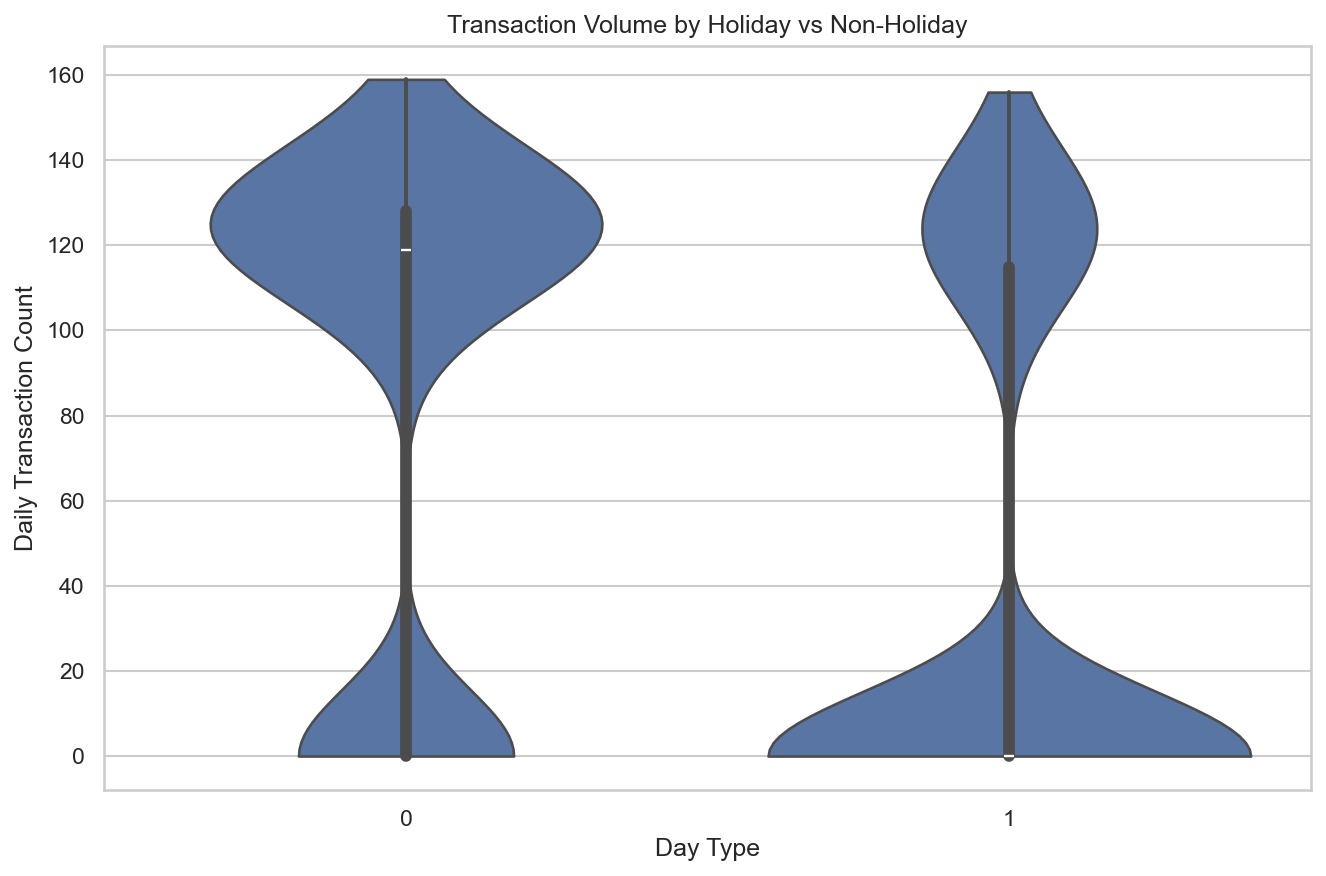


OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     265.4
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           2.68e-55
Time:                        15:05:09   Log-Likelihood:                -8739.8
No. Observations:                1594   AIC:                         1.748e+04
Df Residuals:                    1592   BIC:                         1.749e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept  

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 1. Ensure is_holiday is categorical
df["is_holiday"] = df["is_holiday"].astype("category")

# 2. Daily transaction counts
daily_counts = (
    df.groupby([df["invoice_date"].dt.date, "is_holiday"], observed=False)
      .size()
      .reset_index(name="transaction_count")
)


# 4. Descriptive statistics
desc_table = (
    daily_counts.groupby("is_holiday", observed=False)["transaction_count"]
      .describe()
      .reset_index()
)
print("\nDescriptive statistics of daily transaction count per holiday/non-holiday:")
display(desc_table)

# 5. Violin plot visualization
plt.figure(figsize=(9,6), dpi=150)
sns.violinplot(
    data=daily_counts,
    x="is_holiday",
    y="transaction_count",
    inner="box",
    cut=0
)
plt.xlabel("Day Type")
plt.ylabel("Daily Transaction Count")
plt.title("Transaction Volume by Holiday vs Non-Holiday")
plt.tight_layout()
plt.show()

# 6. OLS regression
model = smf.ols(
    formula="transaction_count ~ C(is_holiday)",
    data=daily_counts
).fit()

print("\nOLS Regression Results:")
print(model.summary())

# 7. Interpret p-value
p_value = model.f_pvalue
if p_value < 0.05:
    print(f"\n✅ Significant difference in transaction volume between holidays and non-holidays. (p={p_value:.4f})")
else:
    print(f"\n❌ No significant difference in transaction volume. (p={p_value:.4f})")


8. day‑of‑week ↔ total_spend / transaction_count <br>
Which day of the week sees the highest revenue and transaction volume?


Descriptive statistics of basket value per day:


,day_of_week,count,mean,std,min,25%,50%,75%,max
0,0,14383.0,2593.106314,4284.337937,5.23,136.35,600.17,2700.72,26250.0
1,1,14217.0,2553.147405,4239.927844,5.23,136.35,600.17,2700.72,26250.0
2,2,14120.0,2519.521964,4204.323090,5.23,136.35,600.17,2700.72,26250.0
3,3,14129.0,2529.418121,4228.346346,5.23,130.75,600.17,2700.72,26250.0
4,4,14347.0,2490.299811,4139.072171,5.23,130.75,600.17,2700.72,26250.0
5,5,14121.0,2491.312848,4205.484410,5.23,136.35,600.17,2700.72,26250.0
6,6,14140.0,2523.980948,4254.297418,5.23,130.75,600.17,2700.72,26250.0


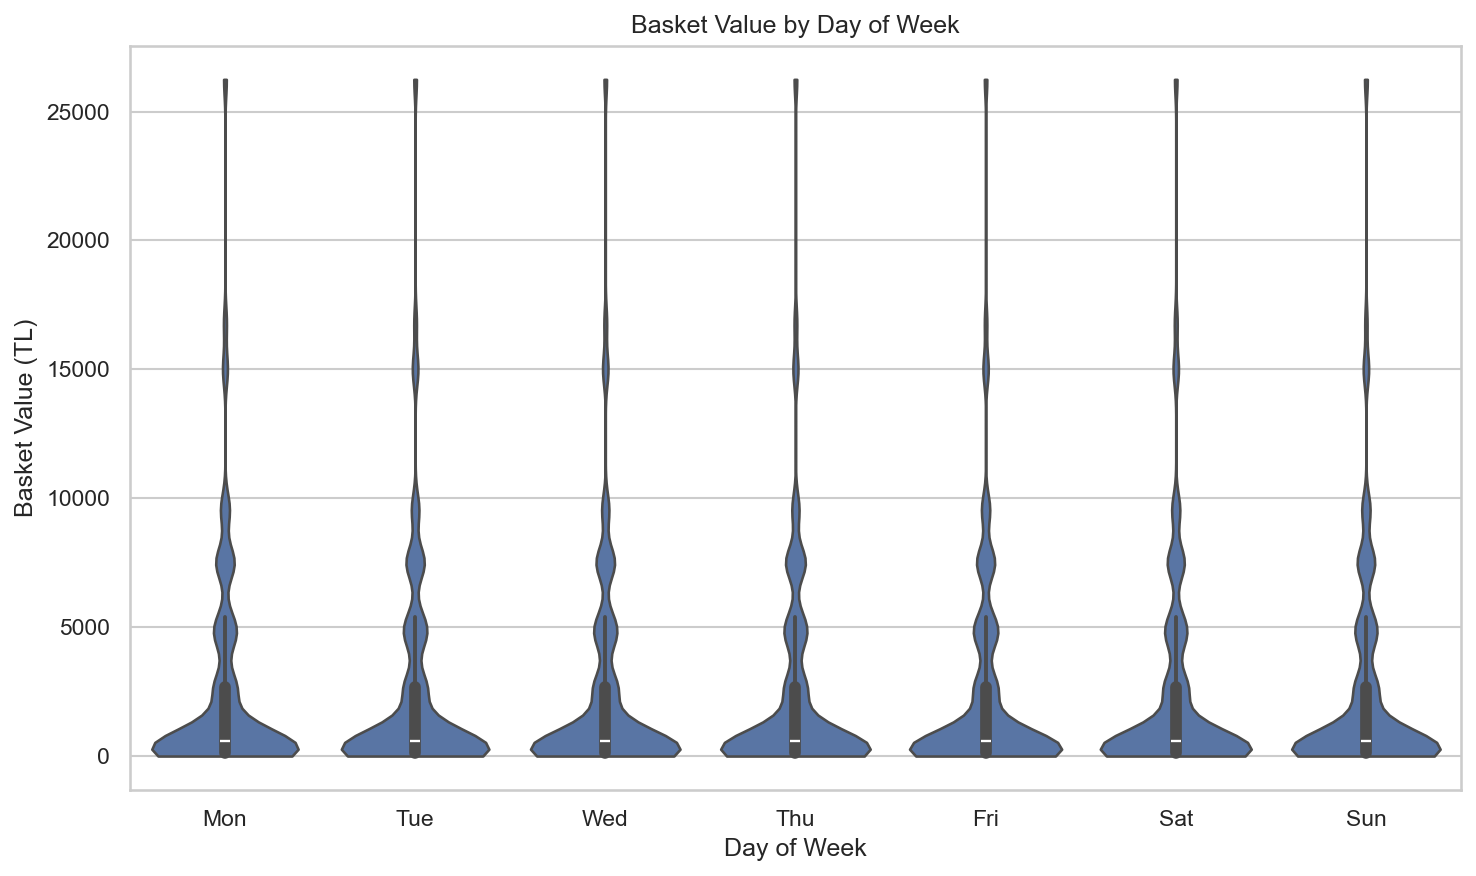


Basket Value Regression by Day of Week:
                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.034
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.401
Time:                        15:07:14   Log-Likelihood:            -9.7140e+05
No. Observations:               99457   AIC:                         1.943e+06
Df Residuals:                   99450   BIC:                         1.943e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 1. Extract day of week
df["day_of_week"] = df["invoice_date"].dt.dayofweek  # Monday=0, Sunday=6
df["day_of_week"] = df["day_of_week"].astype("category")

# 2. Average basket value per day
revenue_avg = (
    df.groupby("day_of_week", observed=False)["total_price"]
      .mean()
      .reset_index(name="avg_basket_value")
      .sort_values("avg_basket_value", ascending=False)
)

# 3. Descriptive statistics
desc_revenue = (
    df.groupby("day_of_week", observed=False)["total_price"]
      .describe()
      .reset_index()
)
print("\nDescriptive statistics of basket value per day:")
display(desc_revenue)

# 4. Violin plot basket value
plt.figure(figsize=(10,6), dpi=150)
sns.violinplot(
    data=df,
    x="day_of_week",
    y="total_price",
    inner="box",
    cut=0
)
plt.xlabel("Day of Week")
plt.ylabel("Basket Value (TL)")
plt.title("Basket Value by Day of Week")
plt.xticks(ticks=range(7), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.tight_layout()
plt.show()

# 5. OLS regression basket value
model_revenue = smf.ols(
    formula="total_price ~ C(day_of_week)",
    data=df
).fit()

print("\nBasket Value Regression by Day of Week:")
print(model_revenue.summary())

p_revenue = model_revenue.f_pvalue
if p_revenue < 0.05:
    print(f"✅ Significant differences in basket value across weekdays. (p={p_revenue:.4f})")
else:
    print(f"❌ No significant differences in basket value across weekdays. (p={p_revenue:.4f})")


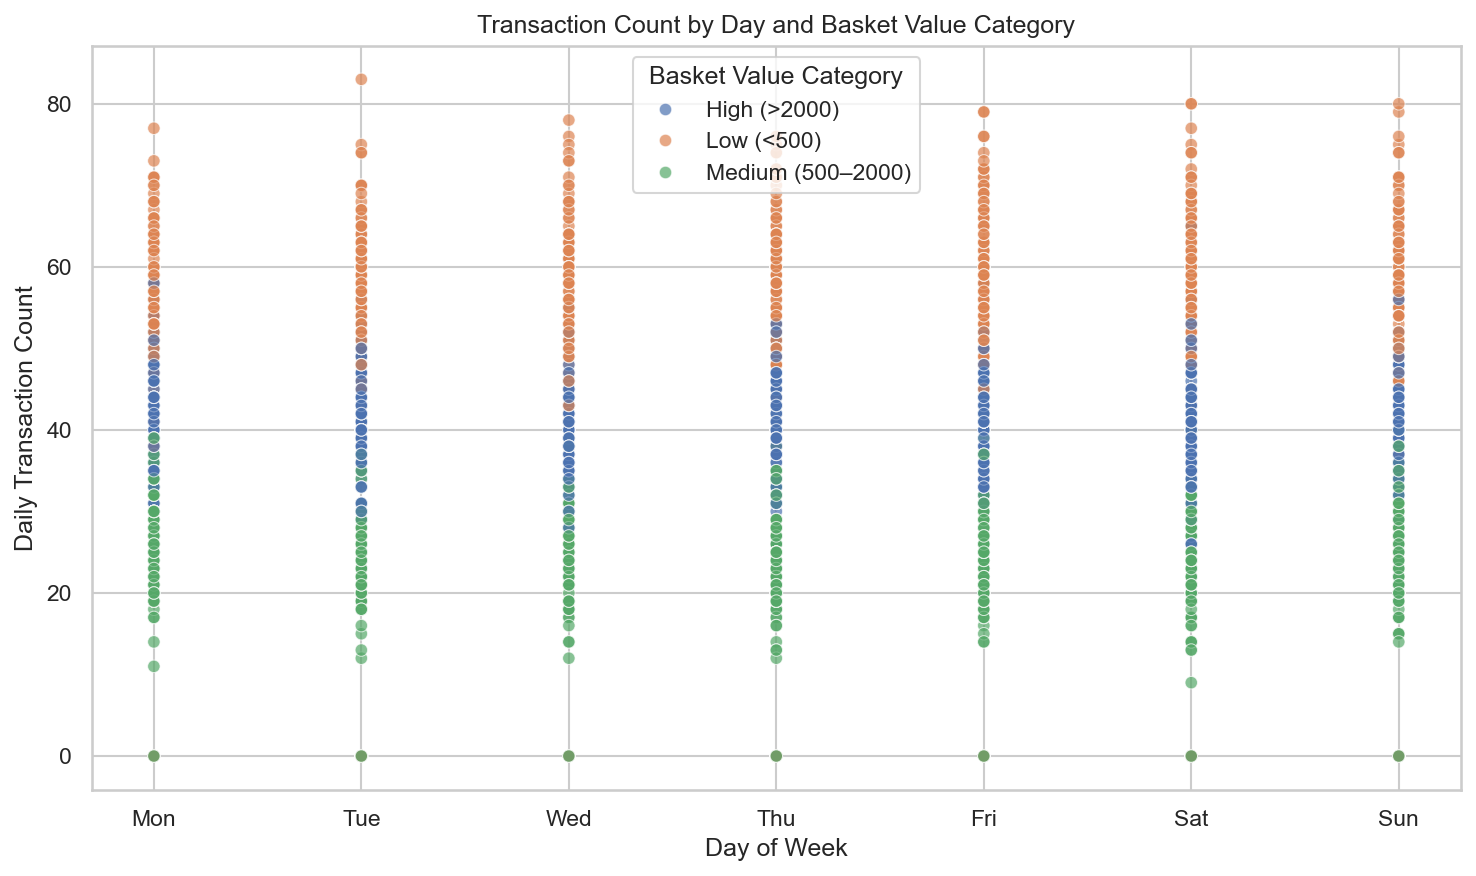

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Categorize basket value
def categorize_spend(x):
    if x < 500:
        return "Low (<500)"
    elif x < 2000:
        return "Medium (500–2000)"
    else:
        return "High (>2000)"

df["spend_category"] = df["total_price"].apply(categorize_spend).astype("category")

# 2. Extract day of week
df["day_of_week"] = df["invoice_date"].dt.dayofweek
df["day_of_week"] = df["day_of_week"].astype("category")

# 3. Daily transaction counts per day and spend category
daily_counts = (
    df.groupby([df["invoice_date"].dt.date, "day_of_week", "spend_category"], observed=False)
      .size()
      .reset_index(name="transaction_count")
)

# 4. Scatter plot
plt.figure(figsize=(10,6), dpi=150)
sns.scatterplot(
    data=daily_counts,
    x="day_of_week",
    y="transaction_count",
    hue="spend_category",
    alpha=0.7
)
plt.xlabel("Day of Week")
plt.ylabel("Daily Transaction Count")
plt.title("Transaction Count by Day and Basket Value Category")
plt.xticks(ticks=range(7), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.legend(title="Basket Value Category")
plt.tight_layout()
plt.show()



Descriptive statistics of daily transaction count per day:


,day_of_week,count,mean,std,min,25%,50%,75%,max
0,0,797.0,18.046424,44.384955,0.0,0.0,0.0,0.0,155.0
1,1,797.0,17.838143,43.845723,0.0,0.0,0.0,0.0,148.0
2,2,797.0,17.716437,43.560417,0.0,0.0,0.0,0.0,159.0
3,3,797.0,17.727729,43.845634,0.0,0.0,0.0,0.0,150.0
4,4,797.0,18.001255,44.294540,0.0,0.0,0.0,0.0,149.0
5,5,797.0,17.717691,43.621538,0.0,0.0,0.0,0.0,151.0
6,6,797.0,17.741531,43.662202,0.0,0.0,0.0,0.0,156.0


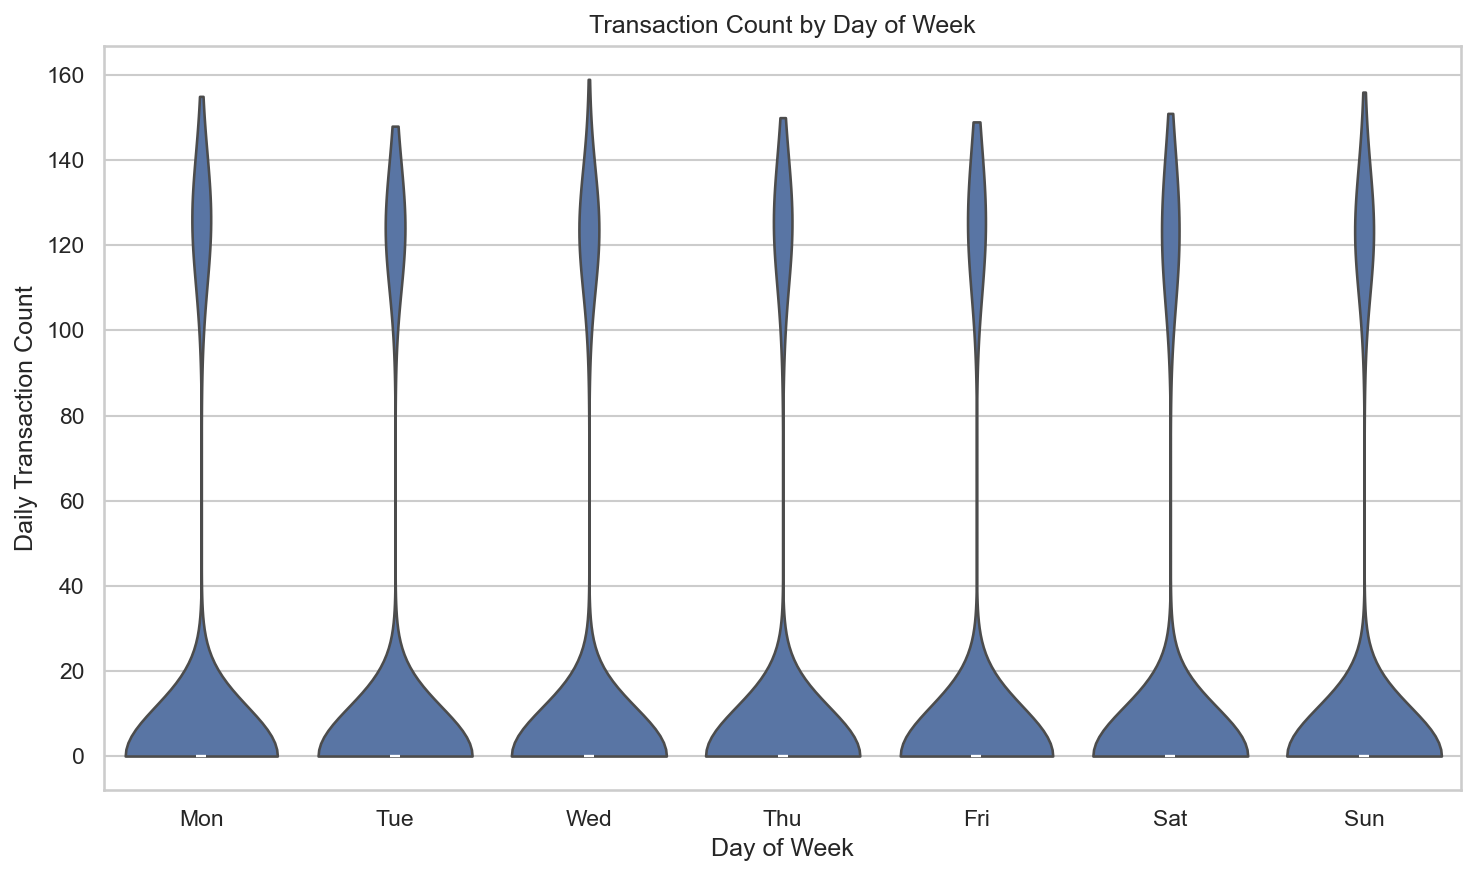


Transaction Count Regression by Day of Week:
                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.008273
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               1.00
Time:                        15:06:37   Log-Likelihood:                -29011.
No. Observations:                5579   AIC:                         5.804e+04
Df Residuals:                    5572   BIC:                         5.808e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 1. Ensure day_of_week is categorical (in case it's a fresh cell)
df["day_of_week"] = df["invoice_date"].dt.dayofweek
df["day_of_week"] = df["day_of_week"].astype("category")

# 2. Transaction count per day
daily_counts = (
    df.groupby([df["invoice_date"].dt.date, df["day_of_week"]], observed=False)
      .size()
      .reset_index(name="transaction_count")
)

# 4. Descriptive statistics
desc_txn = (
    daily_counts.groupby("day_of_week", observed=False)["transaction_count"]
      .describe()
      .reset_index()
)
print("\nDescriptive statistics of daily transaction count per day:")
display(desc_txn)

# 5. Violin plot transaction count
plt.figure(figsize=(10,6), dpi=150)
sns.violinplot(
    data=daily_counts,
    x="day_of_week",
    y="transaction_count",
    inner="box",
    cut=0
)
plt.xlabel("Day of Week")
plt.ylabel("Daily Transaction Count")
plt.title("Transaction Count by Day of Week")
plt.xticks(ticks=range(7), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.tight_layout()
plt.show()

# 6. OLS regression transaction count
model_txn = smf.ols(
    formula="transaction_count ~ C(day_of_week)",
    data=daily_counts
).fit()

print("\nTransaction Count Regression by Day of Week:")
print(model_txn.summary())

p_txn = model_txn.f_pvalue
if p_txn < 0.05:
    print(f"✅ Significant differences in transaction volume across weekdays. (p={p_txn:.4f})")
else:
    print(f"❌ No significant differences in transaction volume across weekdays. (p={p_txn:.4f})")
